# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ Backtesting: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time.

+ One-Step Ahead: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step.

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

This document compares the results of each approach when applied to different forecasters and datasets. To do this, the skforecast functions `grid_search_forecaster`, `bayesian_search_forecaster`, `grid_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` are used to search for the optimal hyperparameters and lags for each forecaster using the backtesting and one-step-ahead methods, respectively. The search is performed on the validation dataset, and the best configuration is then backtested on the test dataset. The time required to perform the search for each method is recorded, as is the performance of the best configuration found.

!!!!!!Mostrar plot con los resultados!!!

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The purpose of this analysis is to compare the time and prediction performance of the two available methods, not to compare different forecasters.

</div>

In [45]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

## Libraries

In [46]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data sets

In [47]:
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)
data_sales = fetch_dataset(name="items_sales", verbose=False)

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data_electricity = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data_electricity = data_electricity.drop(columns="Date")
data_electricity = (
    data_electricity
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data = data_electricity.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00'].copy()

## Single series forecasters

In [48]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_1 = end - start
    metric_1, pred_1 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    metric_2, pred_2 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    print("-----------------")
    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    metrics ({metric}): {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    metrics ({metric}): {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]

### Grid search

In [49]:
# Results
# ==============================================================================
results_grid_search = []
metric = 'mean_absolute_percentage_error'

In [50]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 0.3799842341544775

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 0.24700444066181262

-----------------
Benchmark results
-----------------
Execution time backtesting   : 76.28362393379211
Execution time one step ahead: 7.404402256011963
Same lags  : True
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    metrics (mean_absolute_percentage_error): 0.6832242028204397

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learnin

In [51]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

In [8]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 0.08010331834679393

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 0.4639273059842928

-----------------
Benchmark results
-----------------
Execution time backtesting   : 3.9782679080963135
Execution time one step ahead: 0.2521367073059082
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 10.0}
    metrics (mean_absolute_percentage_error): 0.21632511587222414

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.154434690031882}
    metrics (mean_absolute_percentage_error): 0.18988371358519743


In [9]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 0.11742412854537958

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.46415888336127775}
  Backtesting metric: 0.06301623859411916

-----------------
Benchmark results
-----------------
Execution time backtesting   : 5.108957052230835
Execution time one step ahead: 0.586958646774292
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 10.0}
    metrics (mean_absolute_percentage_error): 0.28557996907774413

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.46415888336127775}
    metrics (mean_absolute_percentage_error): 0.22516595215019208


In [10]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 0.0347412742910817

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 0.012886571425326572

-----------------
Benchmark results
-----------------
Execution time backtesting   : 73.90467691421509
Execution time one step ahe

In [11]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 0.051763869658407506

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 0.2477645831076293

-----------------
Benchmark results
-----------------
Execution time backtesting   : 40.43989825248718
Execution time one step ahead: 0.7597143650054932
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 

In [44]:
results_grid_search = pd.DataFrame(
    results_grid_search,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_grid_search["dataset_forecaster"] = (
    results_grid_search["dataset"]
    + " \n "
    + results_grid_search["forecaster"].str.replace("Forecaster", "")
)
results_grid_search

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,dataset_forecaster
0,bike,ForecasterAutoreg,109.547174,9.173451,0.683224,0.683224,bike \n Autoreg
1,bike,ForecasterAutoregDirect,43.379227,1.119049,1.165963,1.163943,bike \n AutoregDirect
2,website,ForecasterAutoreg,3.978268,0.252137,0.216325,0.189884,website \n Autoreg
3,website,ForecasterAutoregDirect,5.108957,0.586959,0.285580,0.225166,website \n AutoregDirect
4,electricity,ForecasterAutoreg,73.904677,6.951575,0.040936,0.040936,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,40.439898,0.759714,0.058901,0.114416,electricity \n AutoregDirect


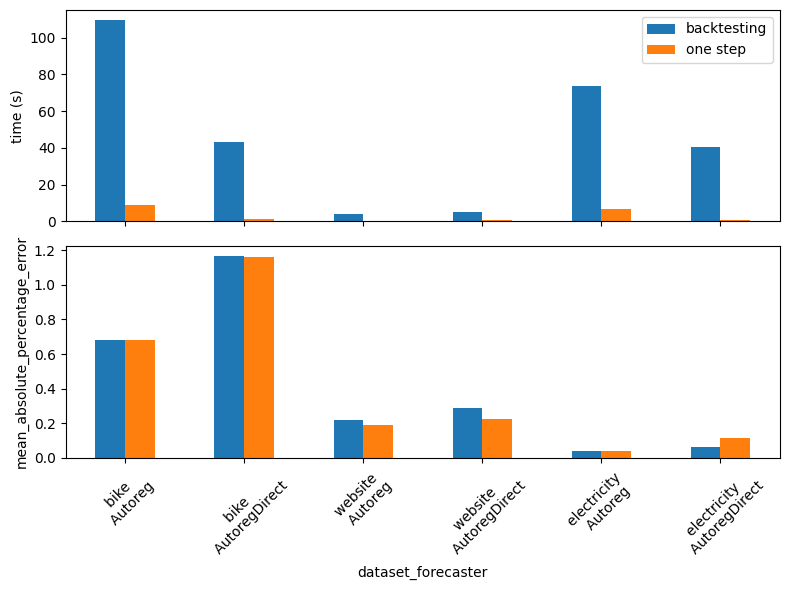

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
results_grid_search.plot.bar(
    x='dataset_forecaster',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_grid_search.plot.bar(
    x='dataset_forecaster',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel(f'{metric}')
plt.xticks(rotation=45)
plt.tight_layout()

### Bayesian search

In [14]:
# Table to store results
# ==============================================================================
results_bayesian_search = []
metric = 'mean_absolute_percentage_error'

In [15]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.19837093299515138, 'gamma': 0.7265577956537549, 'reg_alpha': 0.02906687924014731, 'reg_lambda': 0.7161629054413753}
  Backtesting metric: 0.3578712229887584



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
  Backtesting metric: 0.24085308848335188

-----------------
Benchmark results
-----------------
Execution time backtesting   : 73.18737530708313
Execution time one step ahead: 29.80183506011963
Same lags  : True
Same params: False

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.19837093299515138, 'gamma': 0.7265577956537549, 'reg_alpha': 0.02906687924014731, 'reg_lambda': 0.7161629054413753}
    metrics (mean_absolute_percentage_error): 0.60086764979074

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth

In [16]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'alpha': 15.094374246471325}
  Backtesting metric: 1.081302313301318



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'alpha': 0.0010544569785933518}
  Backtesting metric: 0.9822971800494827

-----------------
Benchmark results
-----------------
Execution time backtesting   : 21.144662141799927
Execution time one step ahead: 1.6009087562561035
Same lags  : True
Same params: False

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 15.094374246471325}
    metrics (mean_absolute_percentage_error): 1.164651073988507

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 0.0010544569785933518}
    metrics (mean_absolute_percentage_error): 1.1639431202081927


In [17]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'alpha': 0.07474245141964296}
  Backtesting metric: 0.08306902098397537



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.03182234592129467}
  Backtesting metric: 0.5027002227984143

-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.5863683223724365
Execution time one step ahead: 0.22611260414123535
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    metrics (mean_absolute_percentage_error): 0.16462827847105585

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    metrics (mean_absolute_percentage_error): 0.1810676656282658


In [18]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 7
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'alpha': 0.07474245141964296}
  Backtesting metric: 0.0822805827836399



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.03182234592129467}
  Backtesting metric: 0.5152580718194439

-----------------
Benchmark results
-----------------
Execution time backtesting   : 2.0020041465759277
Execution time one step ahead: 0.34613585472106934
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    metrics (mean_absolute_percentage_error): 0.1713637163132302

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    metrics (mean_absolute_percentage_error): 0.17314700874646285


In [19]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.0026751307734329544, 'reg_lambda': 0.0033431281459104997}
  Backtesting metric: 0.0320138269276515



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.09236303844911438, 'gamma': 0.7636828414433382, 'reg_alpha': 0.243666374536874, 'reg_lambda': 0.19422296057877086}
  Backtesting metric: 0.01149372890540625

-----------------
Benchmark results
-----------------
Execution time backtesting   : 91.28010082244873
Execution time one step ahead: 26.125784873962402
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.0026751307734329544, 'reg_lambda': 0.00334312814591049

In [20]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 24
             )

lags_grid = (48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169))

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 0.36149961722510493}
  Backtesting metric: 0.05184186084763883



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1717: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'alpha': 15.094374246471325}
  Backtesting metric: 0.24735026617585507

-----------------
Benchmark results
-----------------
Execution time backtesting   : 21.370532035827637
Execution time one step ahead: 0.7677817344665527
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 0.36149961722510493}
    metrics (mean_absolute_percentage_error): 0.05892994271498001

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 15.094374246471325}
    metrics (mean_absolute_percentage_error): 0.11448051588289358


In [21]:
results_bayesian_search = pd.DataFrame(
    results_bayesian_search, 
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_bayesian_search["dataset_forecaster"] = (
    results_bayesian_search["dataset"]
    + " \n "
    + results_bayesian_search["forecaster"].str.replace("Forecaster", "")
)
results_bayesian_search

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,dataset_forecaster
0,bike_sharing,ForecasterAutoreg,73.187375,29.801835,0.600868,0.577674,bike_sharing \n Autoreg
1,bike_sharing,ForecasterAutoregDirect,21.144662,1.600909,1.164651,1.163943,bike_sharing \n AutoregDirect
2,website,ForecasterAutoreg,1.586368,0.226113,0.164628,0.181068,website \n Autoreg
3,website,ForecasterAutoregDirect,2.002004,0.346136,0.171364,0.173147,website \n AutoregDirect
4,electricity,ForecasterAutoreg,91.280101,26.125785,0.038450,0.037349,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,21.370532,0.767782,0.058930,0.114481,electricity \n AutoregDirect


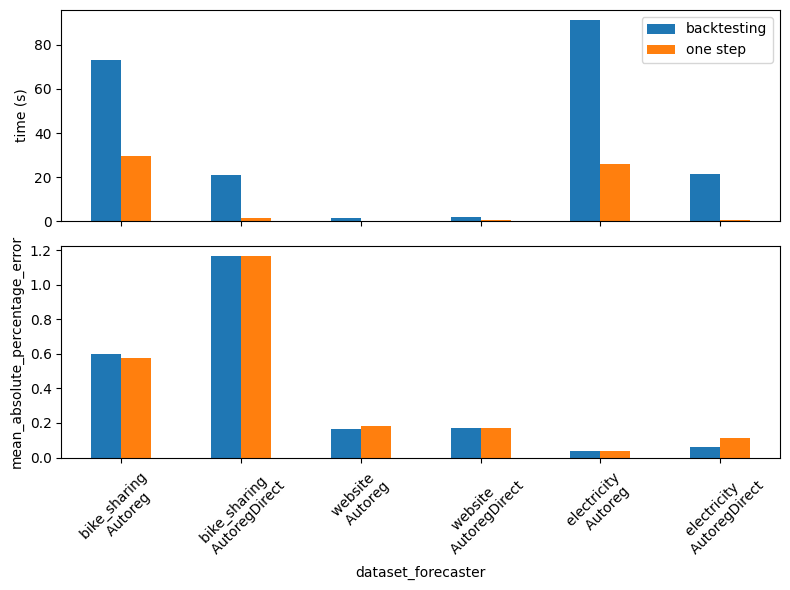

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
results_bayesian_search.plot.bar(
    x='dataset_forecaster',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_bayesian_search.plot.bar(
    x='dataset_forecaster',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel(f'{metric}')
plt.xticks(rotation=45)
plt.tight_layout()

## Global models (multiple series forecasters)

In [23]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        levels             = levels,
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    end = time()
    time_1 = end - start
    metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            initial_train_size  = len(data.loc[:end_validation]),
                            levels              = levels,
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            levels              = levels,
                            initial_train_size  = len(data.loc[:end_validation]),
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    metrics: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    metrics: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]

### Grid search

In [24]:
results_grid_search_multiseries = []
metric = 'mean_absolute_percentage_error'

In [25]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = None 

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_grid_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.1598643419330629
  Levels: ['item_1', 'item_2', 'item_3']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 3, 'n_estimators': 20}
  Backtesting metric: 0.13453016460170986
  Levels: ['item_1', 'item_2', 'item_3']

Benchmark results
-----------------
Execution time backtesting   : 1.5583627223968506
Execution time one step ahead: 0.3763434886932373
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 0.06847429252443214

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 3, 'n_estimators': 20}
    metrics: 0.07604731137860286


In [26]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid ={
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_grid_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.03005814899036344
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.031886325906938455
  Levels: ['item_1']

Benchmark results
-----------------
Execution time backtesting   : 2.740877866744995
Execution time one step ahead: 1.8751609325408936
Same lags  : False
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 0.05243528052941164

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 0.052755349220162076


In [27]:
results_grid_search_multiseries = pd.DataFrame(
    results_grid_search_multiseries,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_grid_search_multiseries["dataset_forecaster"] = (
    results_grid_search_multiseries["dataset"]
    + " \n "
    + results_grid_search_multiseries["forecaster"].str.replace("Forecaster", "")
)
results_grid_search_multiseries

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,dataset_forecaster
0,sales,ForecasterAutoregMultiSeries,1.558363,0.376343,0.068474,0.076047,sales \n AutoregMultiSeries
1,sales,ForecasterAutoregMultiVariate,2.740878,1.875161,0.052435,0.052755,sales \n AutoregMultiVariate


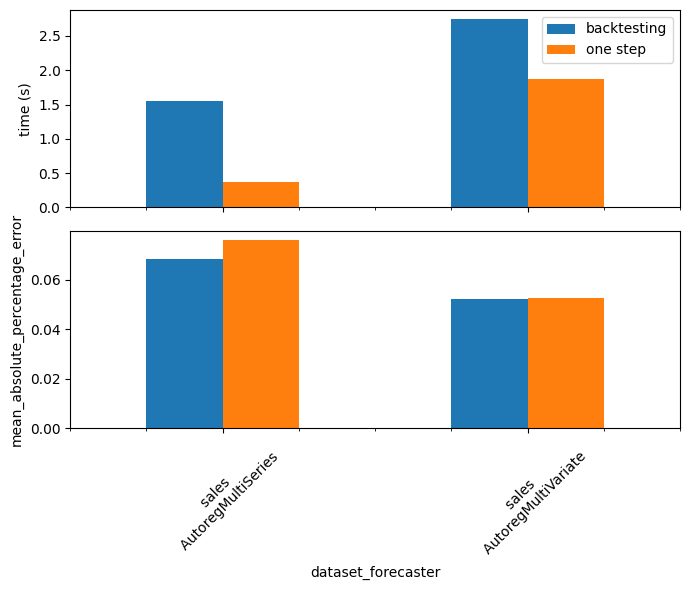

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_grid_search_multiseries.plot.bar(
    x='dataset_forecaster',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_grid_search_multiseries.plot.bar(
    x='dataset_forecaster',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel(f'{metric}')
plt.xticks(rotation=90)
plt.tight_layout()

### Bayesian search

In [29]:
results_bayesian_search_multiseries = []
metric = 'mean_absolute_percentage_error'

In [30]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 50),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_bayesian_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 44, 'max_depth': 10, 'learning_rate': 0.12477980197702984}
  Backtesting metric: 0.1340300469422334
  Levels: ['item_1', 'item_2', 'item_3']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2292: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.1836972385860176}
  Backtesting metric: 0.12013622618153041
  Levels: ['item_1', 'item_2', 'item_3']

Benchmark results
-----------------
Execution time backtesting   : 3.797163486480713
Execution time one step ahead: 1.335913896560669
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 44, 'max_depth': 10, 'learning_rate': 0.12477980197702984}
    metrics: 0.06561342144358918

Method: one step ahead
    lags   

In [31]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 50),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)
results_bayesian_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
  Backtesting metric: 0.031019611941680195
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2292: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no 

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.11386606446550962}
  Backtesting metric: 0.02487432190713256
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 10.776867866516113
Execution time one step ahead: 1.8158040046691895
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
    metrics: 0.051065961357761855

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.11386606446550962}
    metrics: 0.05042669999005982


In [32]:
results_bayesian_search_multiseries = pd.DataFrame(
    results_bayesian_search_multiseries,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_bayesian_search_multiseries["dataset_forecaster"] = (
    results_bayesian_search_multiseries["dataset"]
    + " \n "
    + results_bayesian_search_multiseries["forecaster"].str.replace("Forecaster", "")
)
results_bayesian_search_multiseries

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,dataset_forecaster
0,sales,ForecasterAutoregMultiSeries,3.797163,1.335914,0.065613,0.069925,sales \n AutoregMultiSeries
1,sales,ForecasterAutoregMultiVariate,10.776868,1.815804,0.051066,0.050427,sales \n AutoregMultiVariate


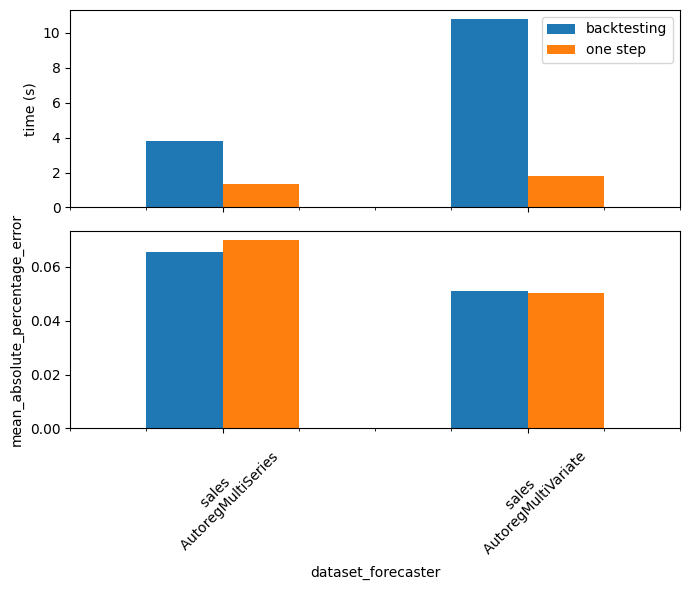

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_bayesian_search_multiseries.plot.bar(
    x='dataset_forecaster',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_bayesian_search_multiseries.plot.bar(
    x='dataset_forecaster',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel(f'{metric}')
plt.xticks(rotation=90)
plt.tight_layout()

# Unit test

## _evaluate_grid_hyperparameters: backtesting vs one-step-ahead

In [34]:
from skforecast.model_selection.model_selection import _evaluate_grid_hyperparameters
from sklearn.model_selection import ParameterGrid

In [35]:
# Data
# ==============================================================================
data = fetch_dataset(
    name="h2o",
    raw=True,
    kwargs_read_csv={"names": ["y", "datetime"], "header": 0},
    verbose=False,
)
data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%d")
data = data.set_index("datetime")
data = data.asfreq("MS")
data = data[["y"]]
data = data.sort_index()
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"
target = "y"
exog_features = None

In [36]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )
lags_grid = [3, 10, [1, 2, 3, 20]]
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 1,
    method             = 'backtesting',
    refit              = False,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    return_best        = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = False
)

results_one_step_ahead = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    method             = 'one_step_ahead',
    return_best        = False,
    verbose            = False,
    show_progress      = False
)

assert results_backtesting.equals(results_one_step_ahead)

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1258: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


## _calculate_metrics_multiseries vs _calculate_metrics_multiseries_one_step_ahead

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries_one_step_ahead
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries
from skforecast.model_selection.model_selection import _create_backtesting_folds
from skforecast.metrics import add_y_train_argument
from skforecast.metrics import mean_absolute_scaled_error

In [38]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [39]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

X, y = forecaster.create_train_X_y(series=data)
X_train = X.loc[X.index <= end_train, :]
y_train = y.loc[y.index <= end_train]
X_test = X.loc[X.index > end_train, :]
y_test = y.loc[y.index > end_train]

forecaster.regressor.fit(X_train, y_train)
pred = forecaster.regressor.predict(X_test)

In [40]:
# Test results _calculate_metrics_multiseries_one_step_ahead and _calculate_metrics_multiseries
# ==============================================================================
# Metrics should be equal when using step=1 in backtesting

# Metrics with _calculate_metrics_multiseries_one_step_ahead
metrics = [mean_absolute_error, mean_absolute_percentage_error, mean_absolute_scaled_error]
metrics = [add_y_train_argument(metric) for metric in metrics]

if forecaster.encoding in ['ordinal', 'ordinal_category']:
    X_train_encoding = forecaster.encoder.inverse_transform(X_train[['_level_skforecast']]).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(X_test[['_level_skforecast']]).ravel()
elif forecaster.encoding == 'onehot':
    X_train_encoding = forecaster.encoder.inverse_transform(
                            X_train.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(
                            X_test.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()

metrics_one_step_ahead = _calculate_metrics_multiseries_one_step_ahead(
    y_true = y_test.to_numpy(),
    y_true_index = y_test.index,
    y_pred = pred,
    y_pred_encoding = X_test_encoding,
    y_train = y_train.to_numpy(),
    y_train_index = y_train.index,
    y_train_encoding = X_train_encoding,
    levels = ['item_1', 'item_2', 'item_3'],
    metrics = metrics,
    add_aggregated_metric = True
)

display(metrics_one_step_ahead)

# Metrics with _calculate_metrics_multiseries
folds = _create_backtesting_folds(
    data = data,
    window_size = 24,
    initial_train_size = len(data_train),
    test_size = 1,
    externally_fitted = False,
    refit = False,
    fixed_train_size = True,
    gap = 0,
    skip_folds = None,
    allow_incomplete_fold = True,
    return_all_indexes = False,
    differentiation = None,
    verbose = False
)
_, predictions = backtesting_forecaster_multiseries(
    series=data,
    forecaster=forecaster,
    steps=1,
    metric=metrics,
    initial_train_size = len(data_train),
    refit=False,
    add_aggregated_metric=True,
    show_progress=False
)
metrics_backtesting = _calculate_metrics_multiseries(
    series = data,
    predictions= predictions,
    folds= folds,
    span_index= data.index,
    window_size = 24,
    metrics= metrics,
    levels= ['item_1', 'item_2', 'item_3'],
    add_aggregated_metric = True
)

display(metrics_backtesting)

assert metrics_backtesting.equals(metrics_one_step_ahead)

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


## _evaluate_grid_hyperparameters_multiseries: backtesting vs one-step-ahead

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries
from skforecast.metrics import mean_absolute_scaled_error

In [42]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()
exog_features = None

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [43]:
forecaster = ForecasterAutoregMultiSeries(
    regressor          = LGBMRegressor(random_state=123, verbose=-1),
    lags               = 24,
    encoding           = 'ordinal',
    transformer_series = None,
    transformer_exog   = None,
    weight_func        = None,
    series_weights     = None,
    differentiation    = None,
    dropna_from_series = False,
    fit_kwargs         = None,
    forecaster_id      = None
)
lags_grid = [3, 10]
param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [2, 3]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            steps                 = 1,
                            metric                = metrics,
                            aggregate_metric      = ['weighted_average', 'average', 'pooling'],
                            initial_train_size    = len(data_train),
                            method                = 'backtesting',
                            fixed_train_size      = True,
                            gap                   = 0,
                            skip_folds            = None,
                            allow_incomplete_fold = True,
                            levels                = None,
                            exog                  = data.loc[:end_validation, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            refit                 = False,
                            n_jobs                = 'auto',
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False,
                            suppress_warnings     = False
                        )

results_one_step_ahead = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            metric                = metrics,
                            initial_train_size    = len(data_train),
                            method                = 'one_step_ahead',
                            exog                  = data.loc[:data_train, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False
                        )

assert results_backtesting.equals(results_one_step_ahead)


/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(
